## Traveling Salesman Problem

The [Traveling Salesman Problem](http://en.wikipedia.org/wiki/Travelling_salesman_problem) (TSP) is quite an interesting math problem. It simply asks: Given a list of cities and the distances between them, what is the shortest possible path that visits each city exactly once and returns to the origin city?

It is a very simple problem to describe and yet very difficult to solve. TSP is known to be [NP-hard](http://en.wikipedia.org/wiki/NP-hard) and a brute-force solution can be incredibly expensive computationally. Even with just $200$ cities, with the brute-force method you have this many possible permutations to check:

In [1]:
import math
math.factorial(200)

788657867364790503552363213932185062295135977687173263294742533244359449963403342920304284011984623904177212138919638830257642790242637105061926624952829931113462857270763317237396988943922445621451664240254033291864131227428294853277524242407573903240321257405579568660226031904170324062351700858796178922222789623703897374720000000000000000000000000000000000000000000000000

That's actually **a lot more** than the total number of atoms in the universe!

Here's an obligatory xkcd for this:

In [2]:
from IPython.display import Image
Image(url='http://imgs.xkcd.com/comics/travelling_salesman_problem.png') 

## Tesla Superchargers

To make the TSP even more exciting, let's make the salesman visit the awesome [Tesla Superchargers](http://www.teslamotors.com/supercharger). As of this writing there are $194$ superchargers in the US, and that number is quickly growing. Let's look at what the optimal path looks like for going through these superchargers as a concrete TSP example.


## Optimal Path for Supercharger Traveling

I'll go through how I obtained the results in the later sections, but first I'd like to present the optimal path that I found below. You can toggle the display for the superchargers and the optimal path by clicking on the checkboxes.  

The optimal path looks pretty awesome, right?

## Solving the TSP

There are numerous heuristics and approximate solutions for TSP and that is on its own a vast topic. An approximate solution called [Christofides's algorithm](http://en.wikipedia.org/wiki/Christofides_algorithm) is provably within $1.5$ times of the optimum. One can also use [simulated annealing](http://en.wikipedia.org/wiki/Simulated_annealing) or [genetic algorithms](http://en.wikipedia.org/wiki/Genetic_algorithm) to find solutions that are very close to optimal in most cases.

But here I'm most interested in finding the exact optimum, since we don't have that many nodes, and the distance metric (symmetric geometric distance) is relatively simple. After surveying the literature and searching online, I found the [Concorde](http://www.math.uwaterloo.ca/tsp/concorde/DOC/index.html) TSP solver that can find the exact optimal path (instead of approximations) using [branch-and-bound algorithms](http://en.wikipedia.org/wiki/Branch_and_bound). The basic idea is that when the algorithm branches out to search for the optimum, many of the permutations can actually be safely cut short if it is impossible for a branch to result in a value better than a known better solution. This kind of method has been shown to be the most effective for finding the exact optimum for TSP.

### Fetching Coordinates

So first we need to find all the supercharger locations. One possible way to do that is to get a list of addresses for them and then [geocode](http://en.wikipedia.org/wiki/Geocoding) the addresses into coordinates. However it turns out that some of the superchargers are in remote places that aren't easily specified by a street address. They are more conveniently specified by latitudes and longitudes.

Luckily the Tesla website contains references to coordinates of all the supercharger locations. We can use simple regular expressions and `BeautifulSoup` to parse the pages.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(15, 5)

In [4]:
from bs4 import BeautifulSoup
import re
import requests
import numpy as np
import pandas as pd

In [5]:
# get the list of superchargers in the US
url = 'http://www.teslamotors.com/findus/list/superchargers/United+States'
rv = requests.get(url)
content = rv.text

In [6]:
# get link to each supercharger, each page contains the supercharger's coordinates
sc_page_urls = re.findall('(/findus/location/supercharger/\w+)', content)

In [7]:
# get the cooridnates (latitude, longitude) for each supercharger
sc_names = []
sc_coors = {}
for sc_page_url in sc_page_urls:
    url = 'http://www.teslamotors.com' + sc_page_url
    rv = requests.get(url)
    soup = BeautifulSoup(rv.text)
    sc_name = soup.find('h1').text
    sc_names.append(sc_name)
    directions_link = soup.find('a', {'class': 'directions-link'})['href']
    lat, lng = directions_link.split('=')[-1].split(',')
    lat, lng = float(lat), float(lng)
    sc_coors[sc_name] = {'lat': lat, 'lng': lng}

In [8]:
coords = pd.DataFrame.from_dict(sc_coors).T.reindex(sc_names)
coords.head()

,lat,lng
Auburn Alabama Supercharger,32.627837,-85.445105
Greenville Supercharger,31.855989,-86.635765
Mobile Supercharger,30.671556,-88.118644
Buckeye Supercharger,33.443011,-112.556876
Casa Grande Supercharger,32.878773,-111.681694


### Computing Geodesic Distances

Now that we've gather all the coordinates, we can start to compute distances. Here is a function that computes the distance between two points on earth specified by latitude-longitude pairs. This function is based on the code on John D. Cook's excellent [blog post](http://www.johndcook.com/blog/python_longitude_latitude/) related to this topic.

In [9]:
def distance_on_earth(lat1, long1, lat2, long2, radius=6378.388):
    """
    Compute distance between two points on earth specified by latitude/longitude.
    The earth is assumed to be a perfect sphere of given radius. The radius defaults
    to 6378.388 kilometers. To convert to miles, divide by 1.60934
    
    Reference
    ---------
    Adopted from John D. Cook's blog post: 
    http://www.johndcook.com/blog/python_longitude_latitude/
    """
    # Convert latitude and longitude to spherical coordinates in radians.
    degrees_to_radians = np.pi / 180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1) * degrees_to_radians
    phi2 = (90.0 - lat2) * degrees_to_radians

    # theta = longitude
    theta1 = long1 * degrees_to_radians
    theta2 = long2 * degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.     
    cos = (np.sin(phi1) * np.sin(phi2)* np.cos(theta1 - theta2) + 
           np.cos(phi1) * np.cos(phi2))
    arc = np.arccos(cos)
    rv = arc * radius
    return rv

Note that we are making the simplifying assumptions that the Earth is a perfect sphere, and that the distance is a simple Euclidean distance, instead of a driving distance. Although one can certainly plug in a different distance metric and follow the same procedure outlined here.

We can now compute the distances between all pairs of supercharger locations:

In [10]:
# get distances between all pairs
mile_in_km = 1.60934
distances = {}
for i in range(len(sc_names)):
    a = sc_names[i]
    distances[a] = {}
    for j in range(len(sc_names)):
        b = sc_names[j]
        if j == i:
            distances[a][b] = 0.
        elif j > i:
            distances[a][b] = distance_on_earth(coords.ix[a, 'lat'],
                                                coords.ix[a, 'lng'],
                                                coords.ix[b, 'lat'],
                                                coords.ix[b, 'lng'])
        else:
            distances[a][b] = distances[b][a]
distances = pd.DataFrame(distances) / mile_in_km

One interesting thing to note is that, for each supercharger in the US, on average there's another one less than $60$ miles away. That's pretty nice. 

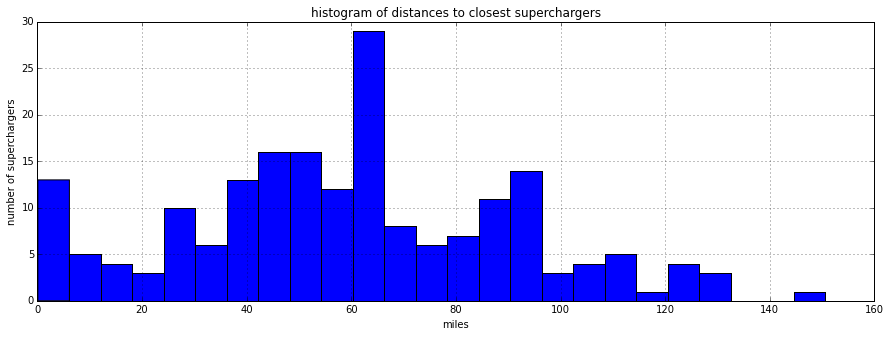

In [11]:
closest_distances = distances[distances > 0].min()
ax = closest_distances.hist(bins=25)
ax.set_title('histogram of distances to closest superchargers')
ax.set_ylabel('number of superchargers')
ax.set_xlabel('miles')

In [12]:
closest_distances.describe()

count    194.000000
mean      59.145575
std       31.628988
min        0.081425
25%       39.773550
50%       59.003213
75%       84.301406
max      150.610963
dtype: float64

### Using the Concorde TSP Solver

Now we are ready to use the [Concorde](http://www.math.uwaterloo.ca/tsp/concorde/DOC/index.html) TSP solver. To use Concorde, you'll need to download a few things and make sure you have a working C compiler. You can find the [detailed steps here](http://davidsjohnson.net/TSPcourse/mac-install-concorde.txt). I compiled it on OSX Yosemite without issues.

Information about the input/output files for Concorde can be found [here](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/). In our particular case, the input file to Concorde can be generated as follows:

In [13]:
# create input file for Concorde TSP solver
sc_id = 0
output = ''
for sc_name in sc_names:
    output += '%d %f %f\n' % (sc_id, sc_coors[sc_name]['lat'], sc_coors[sc_name]['lng'])
    sc_id += 1

header = """NAME : TTS
COMMENT : Traveling Tesla Salesman
TYPE : TSP
DIMENSION : %d
EDGE_WEIGHT_TYPE : GEO
NODE_COORD_SECTION
""" % sc_id

output_file = open('sc.tsp', 'w')
output_file.write(header)
_ = output_file.write(output)
output_file.close()

This creates a `.tsp` file that the `concorde` executable can process directly, and it outputs the solution in a `.sol` file in the same directory where the executable is:

In [14]:
# after running the Concorde executable, parse the output file
solution = []
f = open('../../../../../TSP/concorde/TSP/sc.sol', 'r')
for line in f.readlines():
    tokens = line.split()
    solution += [int(c) for c in tokens]

assert solution[0] == len(sc_names)
solution = solution[1:]  # first number is just the dimension
assert len(solution) == len(sc_names)

Now we have the optimal path!

In [15]:
optimal_path = []
for solution_id in solution:
    # sc_name = sc_names[solution_id]
    optimal_path.append(sc_names[solution_id])

# connect back to the starting node
optimal_path.append(sc_names[solution[0]])
optimal_path = pd.Series(optimal_path)
optimal_path.head()

0    Auburn Alabama Supercharger
1       Chattanooga Supercharger
2           Atlanta Supercharger
3                Atlanta-Decatur
4     Macon Georgia Supercharger
dtype: object

In [16]:
optimal_path.tail()

190         Baton Rouge Supercharger
191              Mobile Supercharger
192    DeFuniak Springs Supercharger
193          Greenville Supercharger
194      Auburn Alabama Supercharger
dtype: object

We can also easily find the total length of the path:

In [17]:
# compute total distance in optimal path
total = 0
for i in range(len(optimal_path) - 1):
    total += distances.ix[optimal_path[i], optimal_path[i + 1]]
total

15917.611537070159

So the total is a bit less than $16,000$ miles, not an easy trip for the salesman!

Finally, we can combine all the results and use the [Google Maps API](https://developers.google.com/maps/documentation/javascript/) to create the visualization in the earlier section. 